In [41]:
%matplotlib inline
import re
import time
import numpy as np
import pandas as pd
import warnings
import operator
from collections import Counter
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=['SimHei']
plt.rcParams["axes.unicode_minus"]=False

import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import f1_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import TruncatedSVD

import xgboost as xgb
import lightgbm as lgb
import catboost as catb

In [42]:
train = pd.read_csv('/kaggle/input/abstract-text-challenge/train.csv')
test = pd.read_csv('/kaggle/input/abstract-text-challenge/test.csv')
testB = pd.read_csv('/kaggle/input/abstract-text-challenge/testB.csv')

In [43]:
file_path = '/kaggle/input/abstract-text-challenge/stop.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    stop_words = file.read()

In [44]:
train

,uuid,title,author,abstract,Keywords,label
0,0,Accessible Visual Artworks for Blind and Visua...,"Quero, Luis Cavazos; Bartolome, Jorge Iranzo; ...",Despite the use of tactile graphics and audio ...,accessibility technology; multimodal interacti...,0
1,1,Seizure Detection and Prediction by Parallel M...,"Li, Chenqi; Lammie, Corey; Dong, Xuening; Amir...","During the past two decades, epileptic seizure...",CNN; Seizure Detection; Seizure Prediction; EE...,1
2,2,Fast ScanNet: Fast and Dense Analysis of Multi...,"Lin, Huangjing; Chen, Hao; Graham, Simon; Dou,...",Lymph node metastasis is one of the most impor...,Histopathology image analysis; computational p...,1
3,3,Long-Term Effectiveness of Antiretroviral Ther...,"Huang, Peng; Tan, Jingguang; Ma, Wenzhe; Zheng...",In order to assess the effectiveness of the Ch...,HIV; ART; mortality; observational cohort stud...,0
4,4,Real-Time Facial Affective Computing on Mobile...,"Guo, Yuanyuan; Xia, Yifan; Wang, Jing; Yu, Hui...",Convolutional Neural Networks (CNNs) have beco...,facial affective computing; convolutional neur...,0
...,...,...,...,...,...,...
5995,5995,ADAPT: A Write Disturbance-Aware Programming T...,"Imran, Muhammad; Kwon, Taehyun; Yang, Joon-Sung","Phase change memory (PCM) is an emerging, resi...",Phase change materials; Programming; Encoding;...,0
5996,5996,Oxy-fuel combustion technology for cement prod...,"Carrasco-Maldonado, Francisco; Spoerl, Reinhol...",Oxy-fuel combustion stands as a promising carb...,Oxy-fuel; Cement sector; Carbon capture; Indus...,0
5997,5997,Ultrasonic‑assisted molten salt hydrates pretr...,"Soo Ling Chong,Inn Shi Tan,Henry Chee Yew Foo,...",This study aims to establish an efficient pret...,Eucheuma cottonii residues; L-lactic acid; dil...,1
5998,5998,Transcriptional Profiling of Pseudomonas aerug...,"Janne G Thöming,Susanne Häussler,Janne G Thömi...",Pseudomonas aeruginosa is an opportunistic pat...,Adaptation; Biofilm formation; Genotype–phenot...,1


# EDA

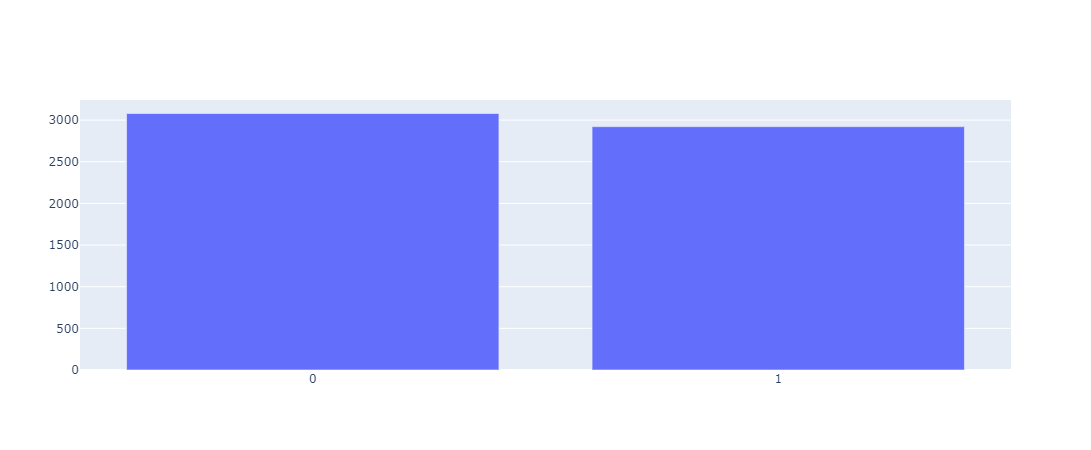

In [45]:
fig = go.Figure(
    data = (
        go.Bar(x = [str(i) for i in train['label'].value_counts().keys().tolist()], 
               y = train['label'].value_counts().tolist()
              )
    )
)

fig.show()

In [46]:
def print_nan(dfs):
    for d in range(len(dfs)):
        df = dfs[d]
        for i in df.columns:
            if df[i].isnull().sum():
                print('在数据集第{}个中的{}列有{}个空值'.format(d, i, df[i].isnull().sum()))
                nan_index = df[i].index[df[i].isna()]
                print(df.iloc[nan_index, :])
print_nan([train, test, testB])

在数据集第1个中的abstract列有1个空值
     uuid                                      title  \
536   536  TMEM100, a Lung-Specific Endothelium Gene   

                                                author abstract  \
536  Bin Liu,Dan Yi,Zhiyun Yu,Jiakai Pan,Karina Ram...      NaN   

                                              Keywords  
536  endothelial cell heterogeneity; endothelium-sp...  


In [47]:
def cleaning(df, columns, stop_words):
    df_ = df.copy()
    for column in columns:
        cleaned = []
        for text in df_[column]:
            try:
                words = re.findall(r'\b\w+\b|[.,!?;]', text)    # 分开标点符号和英文单词
            except Exception as e:
                cleaned.append(' ')
                continue
            cleaned_words = [i for i in words if i.lower() not in stop_words]
            cleaned.append(' '.join(cleaned_words))
        df_['cleaned_' + column] = cleaned
    return df_

cleaned_train = cleaning(train, train.columns[1:-1], stop_words)
cleaned_test = cleaning(test, test.columns[1:], stop_words)
cleaned_testB = cleaning(testB, testB.columns[1:], stop_words)

In [48]:
cleaned_train.head()

,uuid,title,author,abstract,Keywords,label,cleaned_title,cleaned_author,cleaned_abstract,cleaned_Keywords
0,0,Accessible Visual Artworks for Blind and Visua...,"Quero, Luis Cavazos; Bartolome, Jorge Iranzo; ...",Despite the use of tactile graphics and audio ...,accessibility technology; multimodal interacti...,0,Accessible Visual Artworks Blind Visually Impa...,Quero Luis Cavazos Bartolome Jorge Iranzo Cho ...,tactile graphics audio guides blind visually i...,accessibility technology multimodal interactio...
1,1,Seizure Detection and Prediction by Parallel M...,"Li, Chenqi; Lammie, Corey; Dong, Xuening; Amir...","During the past two decades, epileptic seizure...",CNN; Seizure Detection; Seizure Prediction; EE...,1,Seizure Detection Prediction Parallel Memristi...,Chenqi Lammie Corey Dong Xuening Amirsoleimani...,decades epileptic seizure detection prediction...,CNN Seizure Detection Seizure Prediction EEG R...
2,2,Fast ScanNet: Fast and Dense Analysis of Multi...,"Lin, Huangjing; Chen, Hao; Graham, Simon; Dou,...",Lymph node metastasis is one of the most impor...,Histopathology image analysis; computational p...,1,Fast ScanNet Fast Dense Analysis Multi Gigapix...,Huangjing Chen Hao Graham Simon Dou Qi Rajpoot...,Lymph node metastasis indicators breast cancer...,Histopathology image analysis computational pa...
3,3,Long-Term Effectiveness of Antiretroviral Ther...,"Huang, Peng; Tan, Jingguang; Ma, Wenzhe; Zheng...",In order to assess the effectiveness of the Ch...,HIV; ART; mortality; observational cohort stud...,0,Term Effectiveness Antiretroviral Therapy Chin...,Huang Peng Jingguang Wenzhe Zheng Hui Yan Wang...,assess effectiveness Chinese government expand...,HIV mortality observational cohort study China
4,4,Real-Time Facial Affective Computing on Mobile...,"Guo, Yuanyuan; Xia, Yifan; Wang, Jing; Yu, Hui...",Convolutional Neural Networks (CNNs) have beco...,facial affective computing; convolutional neur...,0,Facial Affective Computing Mobile Devices,Guo Yuanyuan Xia Yifan Wang Jing Yu Hui Chen R...,Convolutional Neural Networks CNNs methods com...,facial affective computing convolutional neura...


In [49]:
def high_frequency_words(df, column, num_words=5):
    text = ' '.join(df[column])
        
    words = re.findall(r'\b\w+\b', text.lower())
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

print(high_frequency_words(cleaned_train, 'cleaned_abstract', 10))
print(high_frequency_words(cleaned_test, 'cleaned_abstract', 10))
print(high_frequency_words(cleaned_testB, 'cleaned_abstract', 10))

print('-'*40)

print(high_frequency_words(cleaned_train, 'cleaned_title', 10))
print(high_frequency_words(cleaned_test, 'cleaned_title', 10))
print(high_frequency_words(cleaned_testB, 'cleaned_title', 10))

print('-'*40)

print(high_frequency_words(cleaned_train, 'cleaned_Keywords', 10))
print(high_frequency_words(cleaned_test, 'cleaned_Keywords', 10))

[('based', 4072), ('proposed', 3566), ('data', 3026), ('method', 2929), ('methods', 2685), ('1', 2659), ('performance', 2474), ('model', 2453), ('0', 2407), ('study', 2242)]
[('based', 1577), ('proposed', 1415), ('data', 1185), ('method', 1127), ('methods', 1055), ('1', 1050), ('0', 991), ('performance', 930), ('model', 922), ('image', 894)]
[('energy', 2201), ('economic', 1621), ('study', 1555), ('environmental', 1140), ('1', 1139), ('0', 1059), ('2', 1031), ('development', 963), ('based', 930), ('emissions', 922)]
----------------------------------------
[('based', 712), ('learning', 368), ('image', 348), ('detection', 291), ('deep', 278), ('network', 276), ('networks', 225), ('segmentation', 221), ('analysis', 217), ('multi', 208)]
[('based', 292), ('learning', 155), ('image', 143), ('detection', 115), ('network', 111), ('deep', 100), ('analysis', 91), ('networks', 91), ('segmentation', 91), ('multi', 87)]
[('energy', 319), ('economic', 211), ('analysis', 201), ('china', 199), ('bas

可以发现有些词出现相当频繁，但没个bird用，所以选取tf-idf来进行处理，并且testB明显和另外两个不是同一个出处的

# Representation

testB只有title和abstract

In [50]:
cleaned_train['text'] = (cleaned_train['cleaned_title'] + cleaned_train['cleaned_abstract'])
cleaned_testB['text'] = (cleaned_testB['cleaned_title'] + cleaned_testB['cleaned_abstract'])

In [63]:
vec = TfidfVectorizer()
vec.fit(cleaned_train['text'])
x_train = vec.transform(cleaned_train['text'])
x_test = vec.transform(cleaned_testB['text'])

In [66]:
x_train

<6000x45981 sparse matrix of type '<class 'numpy.float64'>'
	with 437652 stored elements in Compressed Sparse Row format>

# Reduce Dimensionality

## SVD

In [13]:
variances = []
for n_components in range(2, 200):
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(x_train)
    variances.append(np.sum(svd.explained_variance_ratio_))

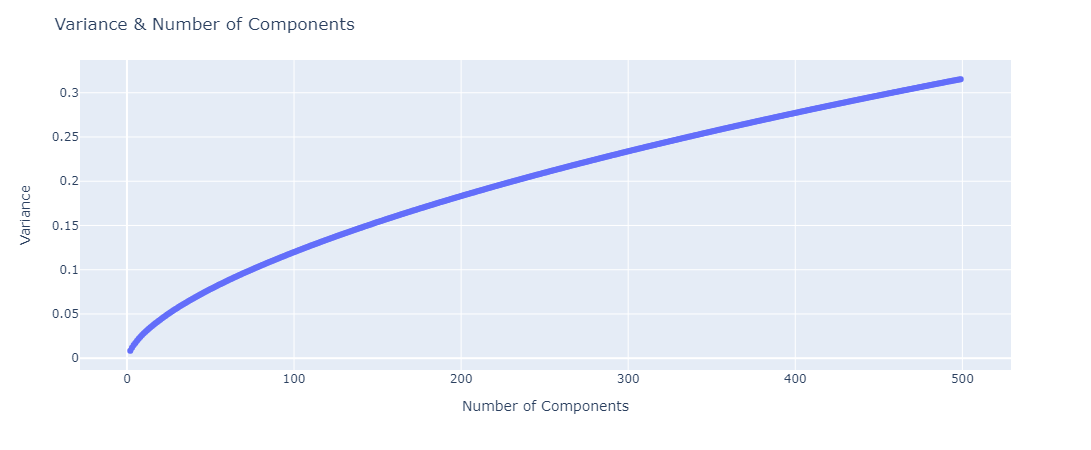

In [14]:
fig = px.line(x=[i for i in range(2, 200)], y=variances, markers=True)
fig.update_layout(title='Variance & Number of Components',
                  xaxis_title='Number of Components',
                  yaxis_title='Variance')
fig.show()

In [120]:
svd1 = TruncatedSVD(n_components = 100)
svd2 = TruncatedSVD(n_components = 100)

x_train_reduction = svd1.fit_transform(x_train)
x_test_reduction = svd2.fit_transform(x_test)
x_train_reduction.shape

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

# Baseline

In [53]:
n_folds = 10
seed = 617

def CV(model, x, y):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    kfold = skf.split(x, y)
    scores = []
    for (train_id, val_id) in kfold:
        x_train = x[train_id]
        y_train = y[train_id]
        x_val = x[val_id]
        y_val = y[val_id]
        model.fit(x_train, y_train)
        pred = model.predict(x_val)
        f1 = f1_score(y_val, pred)
        scores.append(f1)
    return np.mean(scores)

## LightGBM

In [23]:
def objective1(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, 100),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
    }
    
    model = lgb.LGBMClassifier(**param, random_state=seed)
    score = CV(model, x_train, train['label'])
    return score

In [24]:
start = time.time()

study1 = optuna.create_study(direction = 'maximize', study_name="LightGBM")
n_trials = 50
study1.optimize(objective1, n_trials = n_trials)
print('Number of finished trials:', len(study1.trials))
print("------------------------------------------------")
print('Best trial:', study1.best_trial.params)
print("------------------------------------------------")
print('Best values:', study1.best_value)
# print("------------------------------------------------")
# print(study.trials_dataframe())
# print("------------------------------------------------")

end = time.time()
print('It has taken {:.5f} seconds to search for the best Hyperparameter'.format(end-start))

[I 2023-08-15 13:41:29,786] A new study created in memory with name: LightGBM
[I 2023-08-15 13:45:29,140] Trial 0 finished with value: 0.8947988206884775 and parameters: {'n_estimators': 1700, 'reg_alpha': 0.0022964503763171712, 'reg_lambda': 0.3296645824824669, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008793418731205947, 'max_depth': 6, 'num_leaves': 9, 'min_child_samples': 24}. Best is trial 0 with value: 0.8947988206884775.
[I 2023-08-15 13:48:19,875] Trial 1 finished with value: 0.8978626668489254 and parameters: {'n_estimators': 1400, 'reg_alpha': 4.037728380390667, 'reg_lambda': 4.744630265219571, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.0738162174046848, 'max_depth': 18, 'num_leaves': 21, 'min_child_samples': 13}. Best is trial 1 with value: 0.8978626668489254.
[I 2023-08-15 13:50:40,176] Trial 2 finished with value: 0.8933700870311346 and parameters: {'n_estimators': 1600, 'reg_alpha': 2.921447141316703, 'reg_lambda': 0.0013090526504830

Number of finished trials: 50
------------------------------------------------
Best trial: {'n_estimators': 1700, 'reg_alpha': 0.0705666101001917, 'reg_lambda': 0.01590970858081339, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05439352851101248, 'max_depth': 10, 'num_leaves': 5, 'min_child_samples': 5}
------------------------------------------------
Best values: 0.9159725032444381
It has taken 13007.69498 seconds to search for the best Hyperparameter


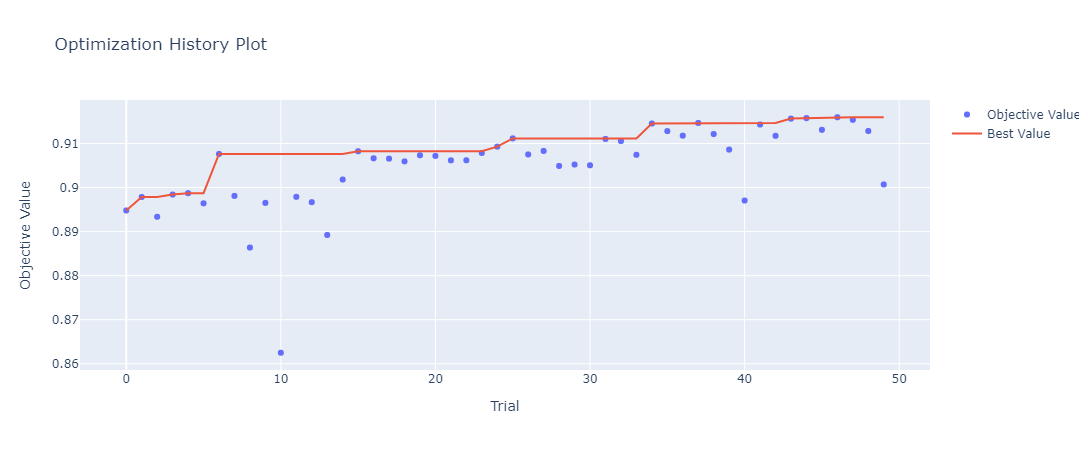

In [25]:
optuna.visualization.plot_optimization_history(study1)

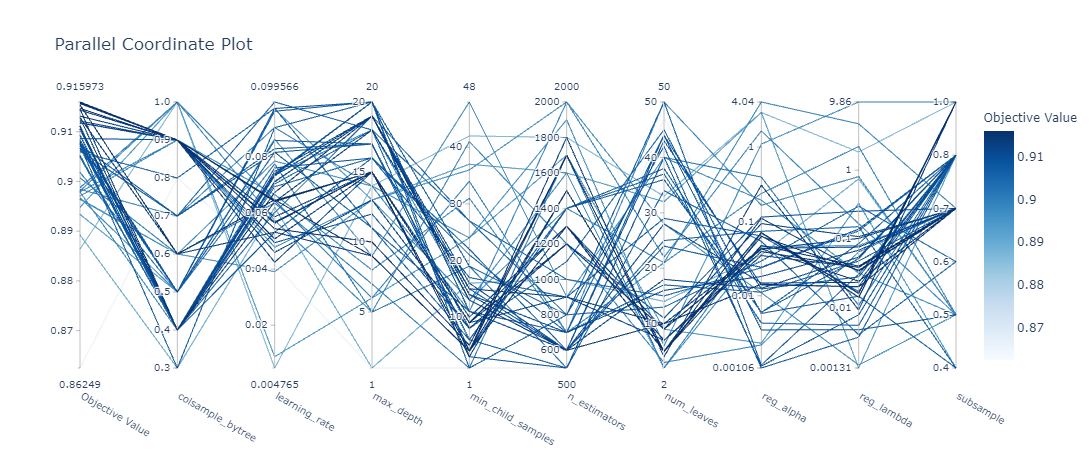

In [26]:
optuna.visualization.plot_parallel_coordinate(study1)

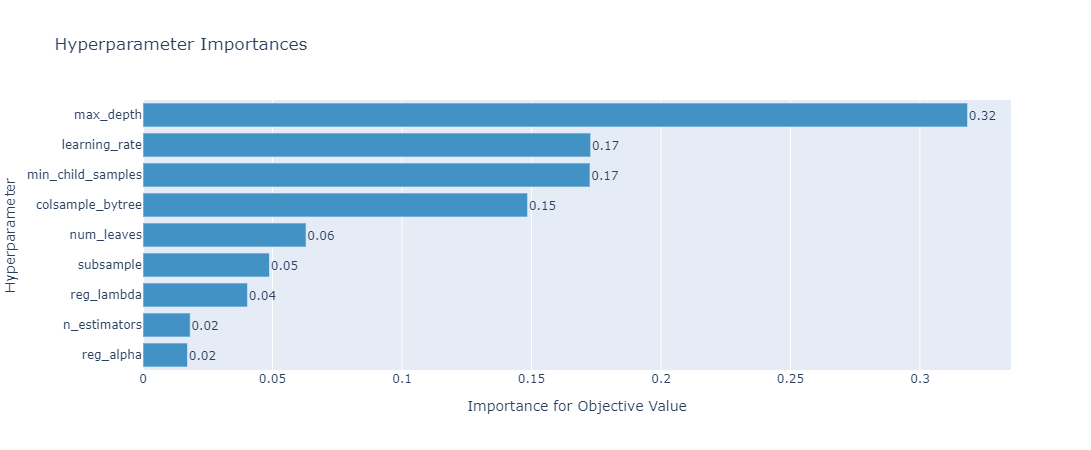

In [27]:
optuna.visualization.plot_param_importances(study1)

In [37]:
def get_metric(model, x, y):
    model.fit(x, y)
    y_predict = model.predict(x)
    acc = sum(y_predict == y) / len(y_predict)
    f1 = f1_score(y, y_predict)
    return f1, acc

In [56]:
# lgbC = lgb.LGBMClassifier(**study1.best_trial.params, random_state = seed)
lgbC = lgb.LGBMClassifier(n_estimators = 1700, reg_alpha = 0.0705666101001917, reg_lambda = 0.01590970858081339, \
                    colsample_bytree = 0.9, subsample = 1.0, learning_rate = 0.05439352851101248, max_depth = 10,\
                    num_leaves = 5, min_child_samples = 5, random_state = seed)
get_metric(lgbC, x_train, train['label'])

(0.9982870846180198, 0.9983333333333333)

In [75]:
# y_pred = lgbC.predict(x_test)

# result = pd.DataFrame()
# result['uuid']= testB['uuid']
# result['label'] = y_pred
# result['Keywords'] = testB['title'].fillna('')
# result.to_csv('submit_task1.csv', index=None)

In [76]:
result

,uuid,label,Keywords
0,0,1,Tobacco Consumption and High-Sensitivity Cardi...
1,1,0,Approaching towards sustainable supply chain u...
2,2,1,Does globalization matter for ecological footp...
3,3,1,Myths and Misconceptions About University Stud...
4,4,1,Antioxidant Status of Rat Liver Mitochondria u...
...,...,...,...
1995,1995,0,The treatment of veterinary antibiotics in swi...
1996,1996,1,Socio-political efficacy explains increase in ...
1997,1997,1,Investigation of early puberty prevalence and ...
1998,1998,1,From 3D printing to 3D bioprinting: the materi...


## XGBoost

In [77]:
def objective2(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, 50),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
    }
    model = xgb.XGBClassifier(**param, random_state = seed)
    score = CV(model, x_train, train['label'])
    return score

In [78]:
start = time.time()

study2 = optuna.create_study(direction = 'maximize', study_name="XGBoost")
n_trials = 40  # 调大一点，这里为了时间
study2.optimize(objective2, n_trials = n_trials)
print('Number of finished trials:', len(study2.trials))
print("------------------------------------------------")
print('Best trial:', study2.best_trial.params)
print("------------------------------------------------")
print('Best values:', study2.best_value)
# print("------------------------------------------------")
# print(study.trials_dataframe())
# print("------------------------------------------------")

end = time.time()
print('It has taken {:.5f} seconds to search for the best Hyperparameter'.format(end-start))

[I 2023-08-15 18:39:31,713] A new study created in memory with name: XGBoost
[I 2023-08-15 18:43:19,389] Trial 0 finished with value: 0.849220377340208 and parameters: {'n_estimators': 250, 'lambda': 5.01712827867124, 'alpha': 0.00897115046033581, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01359107560812152, 'max_depth': 12, 'min_child_weight': 19}. Best is trial 0 with value: 0.849220377340208.
[I 2023-08-15 18:54:31,380] Trial 1 finished with value: 0.7915968710347164 and parameters: {'n_estimators': 850, 'lambda': 0.2117985105411881, 'alpha': 0.08866373274766526, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.058049292687882906, 'max_depth': 5, 'min_child_weight': 35}. Best is trial 0 with value: 0.849220377340208.
[W 2023-08-15 18:55:02,681] Trial 2 failed with parameters: {'n_estimators': 400, 'lambda': 0.001490823633005317, 'alpha': 3.8119558561456155, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.08535521251591309, 'max_depth': 5

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_optimization_history(study2)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study2)

In [ ]:
optuna.visualization.plot_param_importances(study2)

In [ ]:
xgbC = xgb.XGBClassifier(**study2.best_trial.params, random_state = seed)
get_metric(xgbC, x_train, train['label'])

## CatBoost

In [ ]:
def objective3(trial):
    param = {
        'iterations': trial.suggest_int('n_estimators', 200, 1000, 50),
        'learning_rate':trial.suggest_float('learning_rate', 1e-5, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
        'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    model = catb.CatBoostClassifier(**param, random_state = seed)
    score = CV(model, x_train, train['label'])
    return score

In [ ]:
start = time.time()

study3 = optuna.create_study(direction = 'maximize', study_name="CatBoost")
n_trials = 40
study3.optimize(objective3, n_trials = n_trials)
print('Number of finished trials:', len(study3.trials))
print("------------------------------------------------")
print('Best trial:', study3.best_trial.params)
print("------------------------------------------------")
print('Best values:', study3.best_value)
# print("------------------------------------------------")
# print(study.trials_dataframe())
# print("------------------------------------------------")

end = time.time()
print('It has taken {:.5f} seconds to search for the best Hyperparameter'.format(end-start))

In [ ]:
optuna.visualization.plot_optimization_history(study3)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study3)

In [ ]:
optuna.visualization.plot_param_importances(study3)

In [ ]:
catbC = catb.CatBoostClassifier(**study3.best_trial.params, random_state = seed)
get_metric(catbC, x_train, train['label'])

# Ensemble

## Voting

In [ ]:
lgbC = lgb.LGBMClassifier(**study1.best_trial.params, random_state = seed)
xgbC = xgb.XGBClassifier(**study2.best_trial.params, random_state = seed)
catbC = catb.CatBoostClassifier(**study3.best_trial.params, random_state = seed)

voting_clf = VotingClassifier(estimators=[('LightGBM', clf1), ('XGBoost', clf2), ('CatBoost', clf3)], voting='soft')

voting_clf.fit(x_train, train['label'])

y_pred = voting_clf.predict(x_test)

In [ ]:
result = testB['uuid']
result['label'] = y_pred
result['Keywords'] = testB['title'].fillna('')
result.to_csv('submit_task1.csv', index=None)